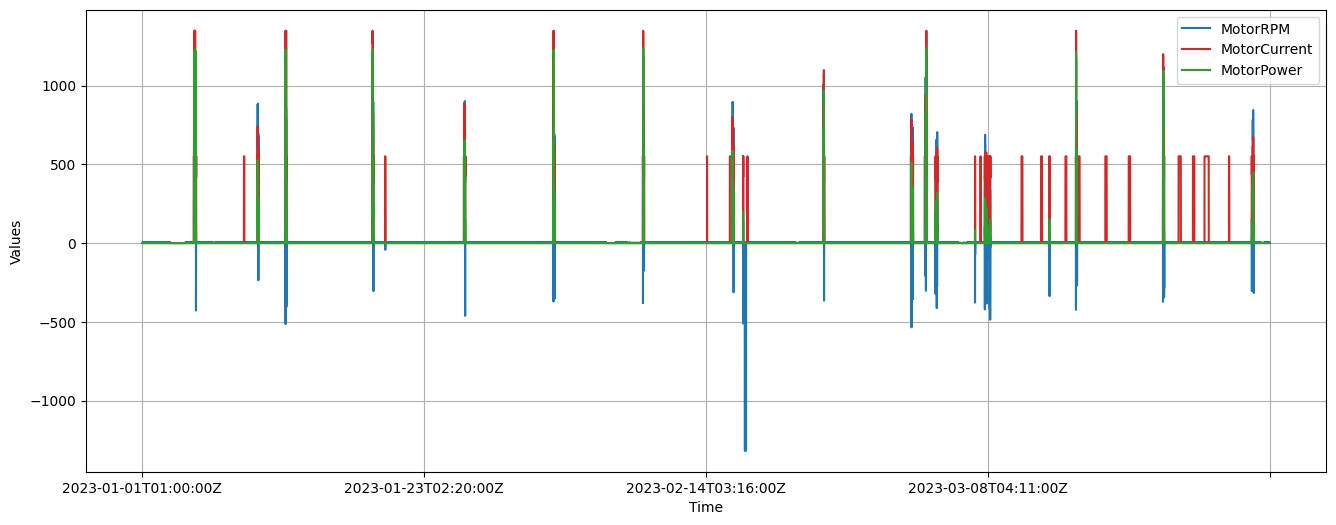

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from influxdb import InfluxDBClient
from sklearn.preprocessing import MinMaxScaler

# Connect to InfluxDB and fetch data
client = InfluxDBClient(host='localhost', port=8086)
client.switch_database('ISS')
query = 'SELECT * FROM "EP_Propulsion1.Thing_HMD8310" WHERE time >= \'2023-01-01T01:00:00Z\' AND time < \'2023-04-01T00:00:00Z\''
results = client.query(query)
df_train = pd.DataFrame.from_records(results.get_points())

# Convert MotorRPM, MotorCurrent, and MotorPower columns to numeric
df_train['MotorRPM'] = pd.to_numeric(df_train['MotorRPM'])
df_train['MotorCurrent'] = pd.to_numeric(df_train['MotorCurrent'])
df_train['MotorPower'] = pd.to_numeric(df_train['MotorPower'])

# Set up the plot
fig, ax_train = plt.subplots(figsize=(16, 6))

# Plot MotorRPM as a line
ax_train.plot(df_train['time'], df_train['MotorRPM'], label='MotorRPM', color='tab:blue',  linestyle='-')

# Plot MotorCurrent as a line
ax_train.plot(df_train['time'], df_train['MotorCurrent'], label='MotorCurrent', color='tab:red', linestyle='-')

# Plot MotorPower as a line
ax_train.plot(df_train['time'], df_train['MotorPower'], label='MotorPower', color='tab:green', linestyle='-')

# Set x-axis ticks and grid
total_len = len(df_train.index)
ax_train.set_xticks(np.arange(0, total_len + 1, total_len / 4))
ax_train.grid(True)

# Set labels and legend
ax_train.set_xlabel('Time')
ax_train.set_ylabel('Values')
ax_train.legend()

# Show the plot
plt.show()


In [44]:
# Add 'MotorPowerTrue' field based on MotorPower
df_train['MotorPowerTrue'] = abs(df_train['MotorPower']) > 0

# Initialize a new 'TrainingArea' field with False values
df_train['TrainingArea'] = False

# Initialize variables to track continuous counts
continuous_true = 0
continuous_false = 0

# Criteria for starting and ending training areas
start_criteria = 30
end_criteria = 30

# Flag to track training state
train_state = False

# Iterate through the 'MotorPowerTrue' column
for index, is_motor_power_true in enumerate(df_train['MotorPowerTrue']):
    if train_state:
        df_train.loc[index, 'TrainingArea'] = True
    else:
        df_train.loc[index, 'TrainingArea'] = False

    if is_motor_power_true: 
        continuous_true += 1
        continuous_false = 0
    else: 
        continuous_false += 1
        continuous_true = 0

    # Check for the start of a training area
    if continuous_true == start_criteria:
        if not train_state:
            train_state = True
            # Set the previous (start_criteria + 10) points to True
            for i in range(start_criteria + 20):
                df_train.loc[index - i, 'TrainingArea'] = True

    # Check for the end of a training area
    elif continuous_false == end_criteria:
        if train_state:
            train_state = False
            # Set the previous (end_criteria + 10) points to False
            for i in range(end_criteria + 20):
                df_train.loc[index - i, 'TrainingArea'] = False

# Initialize lists to store the start and end points of the ranges
start_points = []
end_points = []

# Initialize variables to track the start and end of a range
range_start = None
range_end = None

# Iterate through the 'TrainingArea' column to find ranges
for index, is_training_area in enumerate(df_train['TrainingArea']):
    if is_training_area:  # True
        if range_start is None:
            range_start = df_train['time'][index]  # Set the start point of the range

        range_end = df_train['time'][index]  # Update the end point of the range
    else:  # False
        if range_start is not None:
            # If the current point is not in the training area, save the range
            start_points.append(range_start)
            end_points.append(range_end)
            range_start = None  # Reset the start point
            range_end = None    # Reset the end point

# Check if a range is open when reaching the end of the DataFrame
if range_start is not None:
    start_points.append(range_start)
    end_points.append(range_end)

# Convert the lists to arrays
start_points_array = np.array(start_points)
end_points_array = np.array(end_points)

# Print or use the start_points_array and end_points_array as needed
print("Range count:", len(start_points_array))
print("Start Points:", start_points_array)

Range count: 15
Start Points: ['2023-01-05T01:27:00Z' '2023-01-10T00:45:00Z' '2023-01-12T04:35:00Z'
 '2023-01-19T00:47:00Z' '2023-01-26T04:46:00Z' '2023-02-02T04:32:00Z'
 '2023-02-09T04:37:00Z' '2023-02-16T04:14:00Z' '2023-02-23T07:21:00Z'
 '2023-03-03T06:51:00Z' '2023-03-04T01:39:00Z' '2023-03-07T22:16:00Z'
 '2023-03-16T05:01:00Z' '2023-03-23T00:30:00Z' '2023-03-30T00:38:00Z']


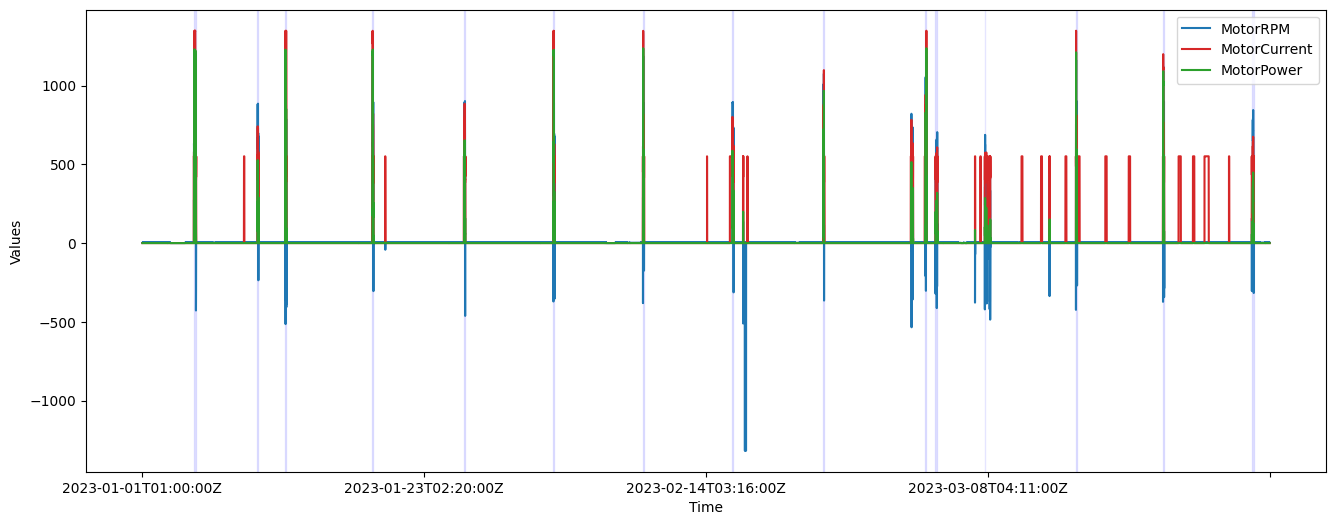

In [46]:

# Set up the plot
fig, ax_train = plt.subplots(figsize=(16, 6))

# Plot MotorRPM as a line
ax_train.plot(df_train['time'], df_train['MotorRPM'], label='MotorRPM', color='tab:blue',  linestyle='-')

# Plot MotorCurrent as a line
ax_train.plot(df_train['time'], df_train['MotorCurrent'], label='MotorCurrent', color='tab:red', linestyle='-')

# Plot MotorPower as a line
ax_train.plot(df_train['time'], df_train['MotorPower'], label='MotorPower', color='tab:green', linestyle='-')

# Set labels and legend
ax_train.set_xlabel('Time')
ax_train.set_ylabel('Values')
ax_train.legend()

# Add shaded regions for the training areas
for i in range(len(start_points_array)):
    ax_train.axvspan(start_points_array[i], end_points_array[i], color='blue', alpha=0.1)

# Set x-axis ticks and grid
total_len = len(df_train.index)
ax_train.set_xticks(np.arange(0, total_len + 1, total_len / 4))

# Show the plot
plt.show()

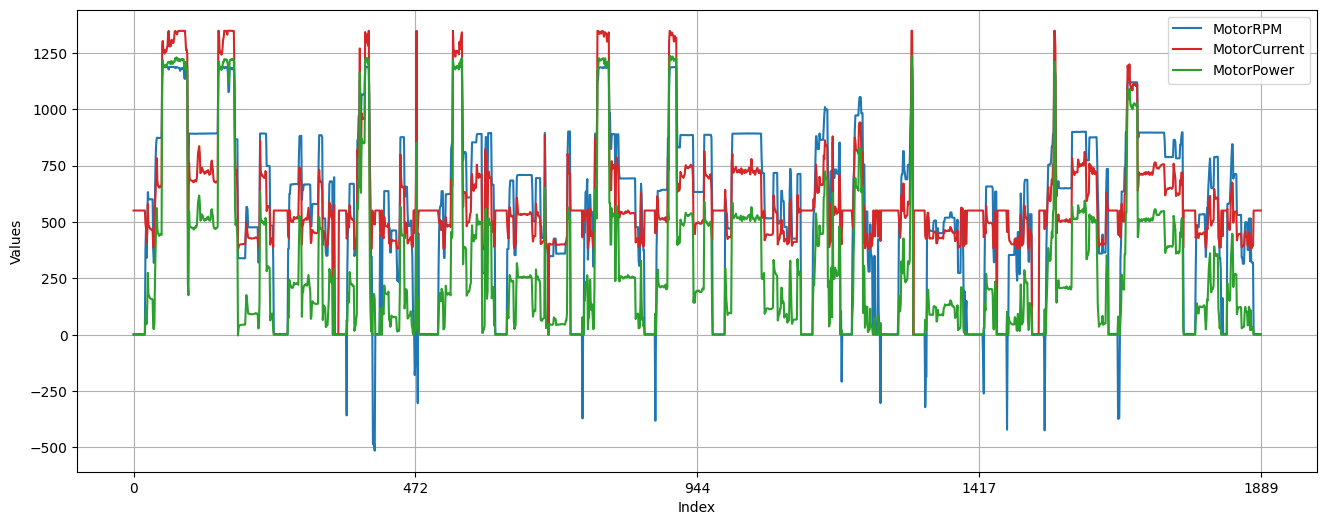

In [74]:
# Filter the DataFrame to create the train dataset
dataset = df_train[df_train['TrainingArea']][['MotorRPM', 'MotorCurrent', 'MotorPower']]

# Reset the index
dataset.reset_index(drop=True, inplace=True)

# Set up the plot
fig, ax_train = plt.subplots(figsize=(16, 6))

# Plot MotorRPM as a line
ax_train.plot(dataset.index, dataset['MotorRPM'], label='MotorRPM', color='tab:blue', linestyle='-')

# Plot MotorCurrent as a line
ax_train.plot(dataset.index, dataset['MotorCurrent'], label='MotorCurrent', color='tab:red', linestyle='-')

# Plot MotorPower as a line
ax_train.plot(dataset.index, dataset['MotorPower'], label='MotorPower', color='tab:green', linestyle='-')

# Set x-axis ticks and grid (you can adjust this according to your needs)
total_len = len(dataset.index)
ax_train.set_xticks(np.arange(0, total_len + 1, total_len / 4))
ax_train.grid(True)

# Set labels and legend
ax_train.set_xlabel('Index')  # You can change this label as needed
ax_train.set_ylabel('Values')
ax_train.legend()

# Show the plot
plt.show()

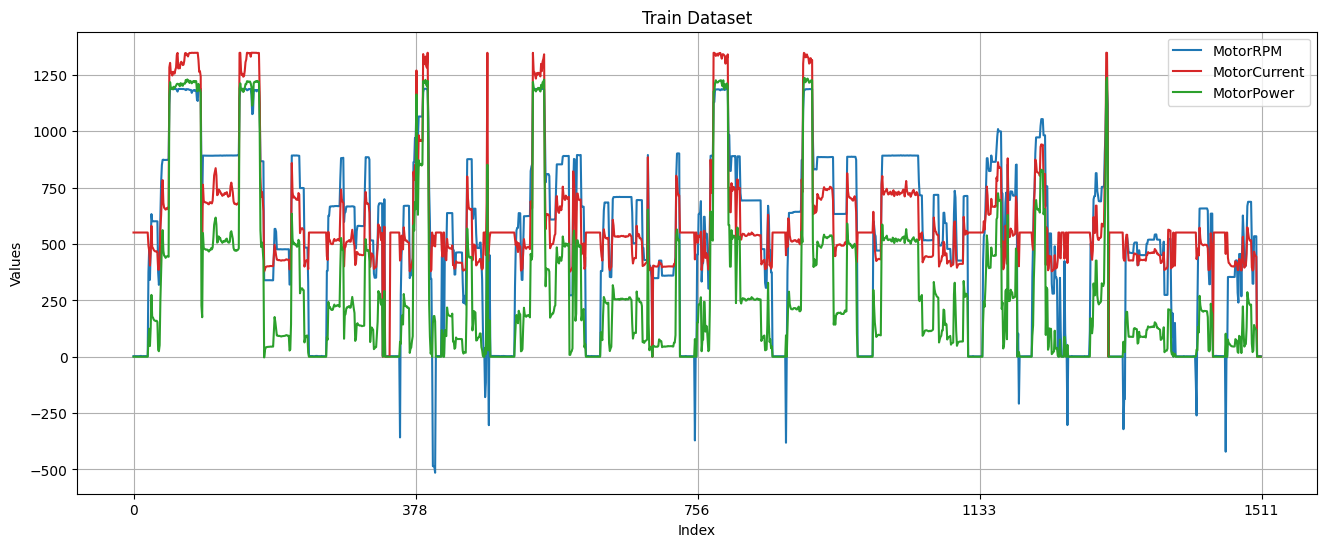

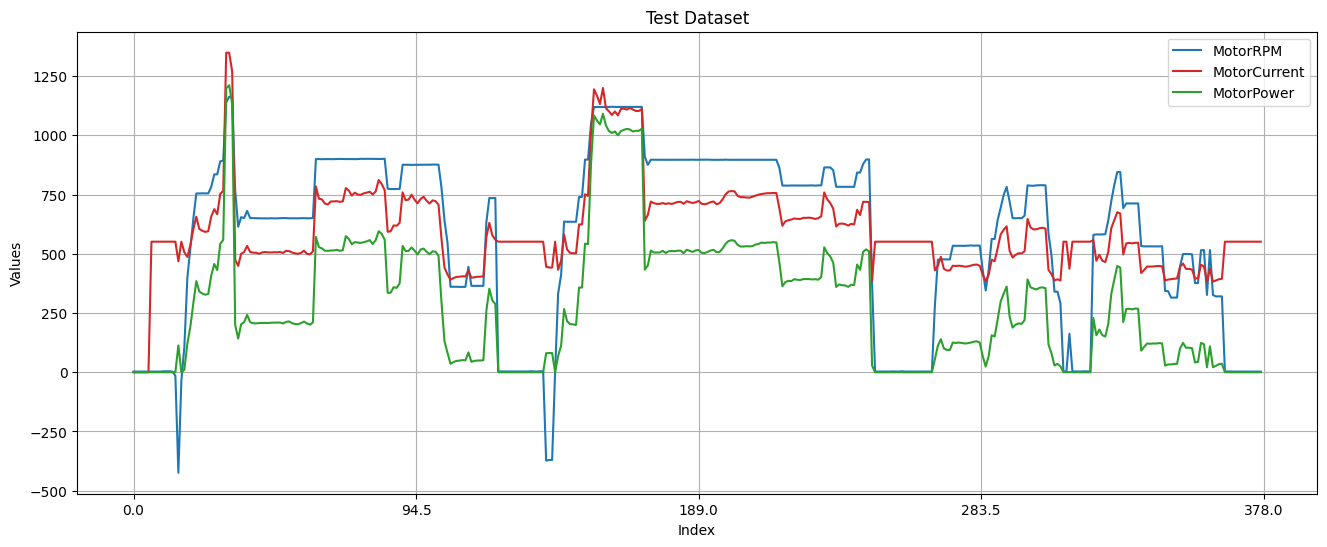

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MotorRPM      1511 non-null   float64
 1   MotorCurrent  1511 non-null   float64
 2   MotorPower    1511 non-null   float64
dtypes: float64(3)
memory usage: 35.5 KB
None


In [83]:
# Define the fraction of data to use for training (e.g., 80% for training, 20% for testing)
train_fraction = 0.8
train_size = int(len(dataset) * train_fraction)

# Split the dataset into train and test sets
train_dataset = dataset.iloc[:train_size]
test_dataset = dataset.iloc[train_size:]

# Reset the index
test_dataset.reset_index(drop=True, inplace=True)


# Set up the plot for the train dataset
fig, ax_train = plt.subplots(figsize=(16, 6))

# Plot MotorRPM as a line
ax_train.plot(train_dataset.index, train_dataset['MotorRPM'], label='MotorRPM', color='tab:blue', linestyle='-')

# Plot MotorCurrent as a line
ax_train.plot(train_dataset.index, train_dataset['MotorCurrent'], label='MotorCurrent', color='tab:red', linestyle='-')

# Plot MotorPower as a line
ax_train.plot(train_dataset.index, train_dataset['MotorPower'], label='MotorPower', color='tab:green', linestyle='-')

# Set x-axis ticks and grid
total_len = len(train_dataset.index)
ax_train.set_xticks(np.arange(0, total_len + 1, total_len / 4))
ax_train.grid(True)

# Set labels and legend
ax_train.set_xlabel('Index')  # Adjust the label as needed
ax_train.set_ylabel('Values')
ax_train.legend()
ax_train.set_title('Train Dataset')

# Show the plot for the train dataset
plt.show()

# Set up the plot for the test dataset
fig, ax_test = plt.subplots(figsize=(16, 6))

# Plot MotorRPM as a line
ax_test.plot(test_dataset.index, test_dataset['MotorRPM'], label='MotorRPM', color='tab:blue', linestyle='-')

# Plot MotorCurrent as a line
ax_test.plot(test_dataset.index, test_dataset['MotorCurrent'], label='MotorCurrent', color='tab:red', linestyle='-')

# Plot MotorPower as a line
ax_test.plot(test_dataset.index, test_dataset['MotorPower'], label='MotorPower', color='tab:green', linestyle='-')

# Set x-axis ticks and grid
total_len = len(test_dataset.index)
ax_test.set_xticks(np.arange(0, total_len + 1, total_len / 4))
ax_test.grid(True)

# Set labels and legend
ax_test.set_xlabel('Index')  # Adjust the label as needed
ax_test.set_ylabel('Values')
ax_test.legend()
ax_test.set_title('Test Dataset')

# Show the plot for the test dataset
plt.show()
print(train_dataset.info())

In [85]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Define the LSTM autoencoder model
def create_lstm_autoencoder(input_shape):
    model = keras.Sequential()
    model.add(layers.LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(layers.LSTM(32, activation='relu', return_sequences=False))
    model.add(layers.RepeatVector(input_shape[0]))  # Repeat the sequence
    model.add(layers.LSTM(32, activation='relu', return_sequences=True))
    model.add(layers.LSTM(64, activation='relu', return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(input_shape[1])))  # TimeDistributed output
    return model

# Define the input shape (sequence_length, num_features)
sequence_length = 10  # Adjust as needed
num_features = 3     # Adjust based on your dataset
input_shape = (sequence_length, num_features)

# Create the LSTM autoencoder model
autoencoder = create_lstm_autoencoder(input_shape)
autoencoder.summary()

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the model (assuming you have 'train_dataset' and 'test_dataset')
num_epochs = 50     # Adjust as needed
batch_size = 32     # Adjust as needed
history = autoencoder.fit(train_dataset, train_dataset, epochs=num_epochs, batch_size=batch_size, validation_data=(test_dataset, test_dataset))

# Predict on test data and calculate reconstruction errors (MSE)
predictions = autoencoder.predict(test_dataset)
mse = np.mean(np.power(test_dataset - predictions, 2), axis=1)  # Mean Squared Error

# Set a threshold for anomaly detection
threshold = 0.9  # You need to determine a suitable threshold

# Detect anomalies in the test dataset
anomalies = mse > threshold

# Visualize results (input data, reconstructed data, and detected anomalies) for the first feature
plt.figure(figsize=(16, 6))
plt.plot(test_dataset.iloc[:, 0], label='Input Data (Feature 1)', color='tab:blue', linestyle='-')
plt.plot(predictions[:, 0], label='Reconstructed Data (Feature 1)', color='tab:orange', linestyle='--')
plt.scatter(np.where(anomalies), test_dataset[anomalies].iloc[:, 0], color='tab:red', label='Anomalies (Feature 1)')
plt.xlabel('Time')
plt.ylabel('Feature 1 Value')
plt.legend()
plt.title('Anomaly Detection Results (Feature 1)')
plt.show()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 10, 64)            17408     
                                                                 
 lstm_25 (LSTM)              (None, 32)                12416     
                                                                 
 repeat_vector_6 (RepeatVect  (None, 10, 32)           0         
 or)                                                             
                                                                 
 lstm_26 (LSTM)              (None, 10, 32)            8320      
                                                                 
 lstm_27 (LSTM)              (None, 10, 64)            24832     
                                                                 
 time_distributed_6 (TimeDis  (None, 10, 3)            195       
 tributed)                                            

ValueError: in user code:

    File "c:\Work\0.Source\anomaly_detection\.conda\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Work\0.Source\anomaly_detection\.conda\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Work\0.Source\anomaly_detection\.conda\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Work\0.Source\anomaly_detection\.conda\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Work\0.Source\anomaly_detection\.conda\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Work\0.Source\anomaly_detection\.conda\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 10, 3), found shape=(None, 3)
